In [1]:
# !pip3 install --upgrade torch --user
# !pip3 install torchvision --user

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import pickle
import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn


from torchvision import datasets
from torchvision import transforms



In [2]:
# !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip -O ../Data/tiny-imagenet-200.zip
# !unzip ../Data/tiny-imagenet-200.zip

In [3]:
event_step = 30720
ada_step = 12
collection_step = 960
readout_step = 800


class EventSamplerDataset(torch.utils.data.Dataset):
    def __init__(self, path_clear='/data/martemev/output_data/',
                 path_noise='/data/martemev/input_noised_data/'):
        super().__init__()
        self.path_clear = path_clear
        self.path_noise = path_noise
                
        
    def __len__(self):
        return 100

        
    def __getitem__(self, index):
        clear_data = np.load(os.path.join(self.path_clear, 'onlysignal_evt{}.npy'.format(index+1)))[:, 2:]
        noised_data = np.load(os.path.join(self.path_noise, 'event_{}_noised.npy'.format(index)))[:, 3:]
        if max([clear_data[i*2*readout_step:i*2*readout_step + collection_step].max() for i in range(12)]) == 0:
            return self.__getitem__(index+1)
        return clear_data, noised_data

In [4]:
# right now we are only returning first collection plane

class PaneSamplerDataset(torch.utils.data.Dataset):
    def __init__(self, clear_data, noised_data):
        """
        clear_data, noised_data - torch.Tensor with shapes 30720 x 4492
        """
        super().__init__()
        self.clear_data = clear_data
        self.noised_data = noised_data
        
        self.signal_panes = [1, 2, 5, 6, 9, 10]
        
    def __len__(self):
        return 6
    
    def normalize(self, im):
        return (im - im.min())/(im.max()-im.min())
        
    def __getitem__(self, ind):
        index = self.signal_panes[ind]
        clear_read_panes = self.clear_data[index*(readout_step*2 + collection_step):
                                          (index+1)*(readout_step*2 + collection_step)]
        noised_read_panes = self.noised_data[index*(readout_step*2 + collection_step):
                                            (index+1)*(readout_step*2 + collection_step)]        
        # some of the panes are all zeros
        if clear_read_panes[2*readout_step:].max() == 0:
            return self.__getitem__(ind+1) # duplicate panes 
        return self.normalize(clear_read_panes[2*readout_step:]), self.normalize(noised_read_panes[2*readout_step:])


In [5]:
def twodsoftmax(arr):
    arr_ = arr - arr.max()
    return torch.exp(arr_)/torch.exp(arr_).sum()

def normal_scale(arr):
    return arr/arr.max()
    # return (arr - arr.mean())/arr.std()

class PatchSamplerDataset(torch.utils.data.Dataset):
    def __init__(self, clear_data, noised_data):
        """
        clear_data, noised_data - torch.Tensor with shapes 800 x 4492
        """
        super().__init__()
        
        self.clear_data = torch.Tensor(clear_data)
        self.noised_data = torch.Tensor(noised_data)
                
        # maybe add eps        
        # self.softmax_clear_data = twodsoftmax(self.clear_data)
#         print(self.softmax_clear_data.max())
#         print(self.softmax_clear_data.min())
#         print(self.softmax_clear_data.mean())
#         print(self.softmax_clear_data)
                
#         self.clear_data = (self.clear_data - self.clear_data.mean()) / self.clear_data.std()
#         self.noised_data = (self.noised_data - self.noised_data.mean()) / self.noised_data.std()
#         think about how you can make two images ~ simular distr
        
    def __len__(self):
        return 1000
        
    def __getitem__(self, index):
        distr = torch.distributions.binomial.Binomial(total_count=15, probs=self.clear_data)
        samples = torch.nonzero(distr.sample())
        while len(samples) < 1:
            samples = torch.nonzero(torch.round(distr.sample()))
        sample = np.random.choice(len(samples))
        sample = samples[sample]
#         print(sample)
#         print(self.softmax_clear_data[(int(sample[0]), int(sample[1]))])
        # self.softmax_clear_data[(int(sample[0]), int(sample[1]))] /= 2 ???
        x, y = self.clear_data.shape
        sample = (min(max(int(sample[0]), 16), x-16), min(max(int(sample[1]), 16), y-16))
        clear_crop = self.clear_data[sample[0]-16:sample[0]+16, sample[1]-16:sample[1]+16]

        noised_crop = self.noised_data[sample[0]-16:sample[0]+16, sample[1]-16:sample[1]+16]
        
        return clear_crop.unsqueeze(0), noised_crop.unsqueeze(0)

        

In [6]:
class FullDataset(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        self.event_sampler_iter = iter(EventSamplerDataset(
            path_clear='/data/martemev/output_data/',
            path_noise='/data/martemev/input_noised_data/'
        ))
        self.pane_sampler = PaneSamplerDataset
        self.patch_sampler = PatchSamplerDataset
        
        self.current_event = next(self.event_sampler_iter)
        
        self.current_pane_sampler = self.pane_sampler(*self.current_event)
        self.current_pane_iter = iter(self.current_pane_sampler)
        self.current_pane = next(self.current_pane_iter)

        self.current_patch_iter = iter(self.patch_sampler(*self.current_pane))
        
    def __len__(self):
        # 1000 patches, 6 panes, 100 events
        return 1000*6*100
    
    def __getitem__(self, index):
        try:
            return next(self.current_patch_iter)
        except StopIteration:
            print('One pane finished, going for the next one')
            try:
                self.current_pane = next(self.current_pane_iter)
            except StopIteration:
                print('One event finished, going for the next one')
                try:
                    self.current_event = next(self.event_sampler_iter)
                except StopIteration:
                    print('Dataset is exhausted')
                    raise StopIteration
                self.current_pane_sampler = self.pane_sampler(*self.current_event)
                self.current_pane_iter = iter(self.current_pane_sampler)
                self.current_pane = next(self.current_pane_iter)
            self.current_patch_iter = iter(self.patch_sampler(*self.current_pane))
            return next(self.current_patch_iter)
        

In [7]:
train_dataloader = torch.utils.data.DataLoader(FullDataset(), batch_size=32, num_workers=48)

In [8]:
# event_sampler = EventSamplerDataset()
# event_iterator = iter(event_sampler)
# event = next(event_iterator)

# print(event[0].shape, event[0].max())
# print(event[1].shape, event[1].max())

# pane_sampler = PaneSamplerDataset(*event)
# pane_iterator = iter(pane_sampler)

# for pane in pane_iterator:
#     print(pane[0].shape, pane[0].max())
#     print(pane[1].shape, pane[1].max())

# print(pane[0].shape, pane[0].max())
# print(pane[1].shape, pane[1].max())

# patch_sampler = PatchSamplerDataset(*pane)

# train_loader = torch.utils.data.DataLoader(patch_sampler,
#                                           batch_size=64,
#                                           shuffle=True)

# test_loader = torch.utils.data.DataLoader(dataset_test,
#                                           batch_size=32,
#                                           shuffle=True)

In [9]:
# plt.figure(figsize=(15, 15))

# im, im_noise = next(iter(train_loader))

# for ind in range(1, 37, 2):
#     if ind >= 36: break
#     plt.subplot(6, 6, ind)
#     plt.imshow(im[ind].view(32, 32).numpy())
#     plt.yticks([])
#     plt.xticks([])
    
#     plt.subplot(6, 6, ind+1)
#     plt.imshow(im_noise[ind].view(32, 32).numpy())

# #     plt.title(str(label[0]))

# plt.show()

In [10]:
def get_freer_gpu():
    os.system('nvidia-smi -q -d Memory |grep -A4 GPU|grep Free >tmp')
    memory_available = [int(x.split()[2]) for x in open('tmp', 'r').readlines()]
    return np.argmax(memory_available)


In [11]:
def pairwise_dist(arr, k):
    """
    arr: torch.Tensor with shape batch x h*w x features
    """
#     arr = arr.view(arr.shape[0], arr.shape[1] * arr.shape[2], -1)
    r_arr = torch.sum(arr * arr, dim=2, keepdim=True) # (B,N,1)
    mul = torch.matmul(arr, arr.permute(0,2,1))         # (B,M,N)
    dist = - (r_arr - 2 * mul + r_arr.permute(0,2,1))       # (B,M,N)
    return dist.topk(k=k, dim=-1)[1]


def batched_index_select(t, dim, inds):
    dummy = inds.unsqueeze(2).expand(inds.size(0), inds.size(1), t.size(2))
    out = t.gather(dim, dummy) # b x e x f
    return out


def get_closest_diff(arr, k):
    """
    arr: torch.Tensor with shape batch x h * w x features
    """
    b, hw, f = arr.shape
#     arr = arr.view(b, h*w, f)
    dists = pairwise_dist(arr, k)
    selected = batched_index_select(arr, 1, dists.view(dists.shape[0], -1)).view(b, hw, k, f)
    diff = arr.unsqueeze(2) - selected
    return diff
    

In [12]:
class NonLocalAggregation(nn.Module):
    def __init__(self, k, input_channels, out_channels, search_area=None):
        super().__init__()
        self.k = k
        self.diff_fc = nn.Linear(input_channels, out_channels)
        self.w_self = nn.Linear(input_channels, out_channels)
        self.bias = nn.Parameter(torch.randn(out_channels), requires_grad=True)
        
    def forward(self, x):
        """
        x: torch.Tensor with shape batch x features x h x w
        """
        x = x.permute(0, 2, 3, 1)
        b, h, w, f = x.shape
        x = x.view(b, h*w, f)
        
        closest_graph = get_closest_diff(x, self.k)
        agg_weights = self.diff_fc(closest_graph) # look closer
        agg_self = self.w_self(x)
                
        x_new = torch.mean(agg_weights, dim=-2) + agg_self + self.bias

        return x_new.view(b, h, w, x_new.shape[-1]).permute(0, 3, 1, 2)

In [13]:
class GraphConv(nn.Module):
    def __init__(self, k, input_channels, out_channels, search_area=None):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels, 1)
        self.conv2 = nn.Conv2d(input_channels, out_channels, 3, padding=1)
        self.NLA = NonLocalAggregation(k, input_channels, out_channels)
        
    def forward(self, x):
        return torch.mean(torch.stack([self.conv1(x),
                                       self.conv2(x),
                                       self.NLA(x)]), dim=0)

In [14]:
class PreProcessBlock(nn.Module):
    def __init__(self, k, kernel_size, input_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, out_channels, kernel_size,
                              padding=(kernel_size//2, kernel_size//2))
        self.activ = nn.LeakyReLU(0.05)
        self.bn = nn.BatchNorm2d(out_channels)
        
        self.GC = GraphConv(k, out_channels, out_channels) # out_channels -> out_channels
        
    def forward(self, x):
        x = self.activ(self.conv(x))
        x = self.GC(x)
        x = self.activ(self.bn(x))
        return x

In [15]:
class Residual(nn.Module):
    def __init__(self, k, input_channels, out_channels):
        super().__init__()
        self.pipeline = nn.Sequential(
            GraphConv(k, input_channels, input_channels),
            nn.BatchNorm2d(input_channels),
            nn.LeakyReLU(0.05),
            
            GraphConv(k, input_channels, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.05),
            
            GraphConv(k, out_channels, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.05),
        )
        
    def forward(self, x):
        return self.pipeline(x)

In [16]:
loss_mse = nn.MSELoss()

class DNGNN(nn.Module):
    def __init__(self, k, input_channels, hidden_channels):
        super().__init__()
        self.preprocessing_blocks = nn.ModuleList([
            PreProcessBlock(k, 3, input_channels, hidden_channels),
            PreProcessBlock(k, 5, input_channels, hidden_channels),
            PreProcessBlock(k, 7, input_channels, hidden_channels),
        ])
        self.residual_1 = Residual(k, hidden_channels*3, hidden_channels)
        self.residual_2 = Residual(k, hidden_channels, hidden_channels)
        
        self.GC = GraphConv(k, hidden_channels, input_channels)
        self.downsample = nn.Sequential(
            nn.Conv2d(hidden_channels*3, hidden_channels, 1),
            nn.BatchNorm2d(hidden_channels),
            nn.LeakyReLU(0.05),
            nn.Conv2d(hidden_channels, hidden_channels, 1),
            nn.BatchNorm2d(hidden_channels),
            nn.LeakyReLU(0.05),
        )
        
    def fit_image(self, image):
        processed_image = torch.cat([block(image) for block in self.preprocessing_blocks], dim=1)
        residual_1 = self.residual_1(processed_image)
        result_1 = residual_1 + self.downsample(processed_image)
        residual_2 = self.residual_2(result_1)
        result = residual_2 + result_1
        return [processed_image, residual_1, result, self.GC(result)]
    
    def forward(self, clear_image, noised_image):
        processed_image, residual_1, residual_2, answer = self.fit_image(clear_image)
        n_processed_image, n_residual_1, n_residual_2, n_answer = self.fit_image(noised_image)
        perceptual_loss = loss_mse(processed_image, n_processed_image) + \
            loss_mse(residual_1, n_residual_1) + \
            loss_mse(residual_2, n_residual_2)
        return image + n_answer, perceptual_loss
        

In [17]:
from IPython.display import clear_output

In [18]:
gpu_num = get_freer_gpu()
device = torch.device('cuda:{}'.format(gpu_num))
device

device(type='cuda', index=1)

In [20]:
model = DNGNN(8, 1, 16).cuda(device)
optim = torch.optim.Adam(model.parameters())

In [ ]:
def compute_psnr(image, noised):
    return 10 * np.log10(1/loss_mse(image, noised).item())

In [21]:
loss_mse = nn.MSELoss()
losses = []

In [22]:
def plot_diff(real, noised, denoised):
    plt.figure(figsize=(15, 15))
    
    for ind, im, noise, denoise in zip(range(1, 13, 3), real[:4], noised[:4], denoised[:4]):
        plt.subplot(4, 3, ind)
        plt.imshow(im)
        plt.yticks([])
        plt.xticks([])
        plt.title('Clear image')
        
        plt.subplot(4, 3, ind+1)
        plt.imshow(noise)
        plt.yticks([])
        plt.xticks([])
        plt.title('Noised image')
        
        plt.subplot(4, 3, ind+2)
        plt.imshow(denoise)
        plt.yticks([])
        plt.xticks([])
        plt.title('Denoised image')


    plt.show()

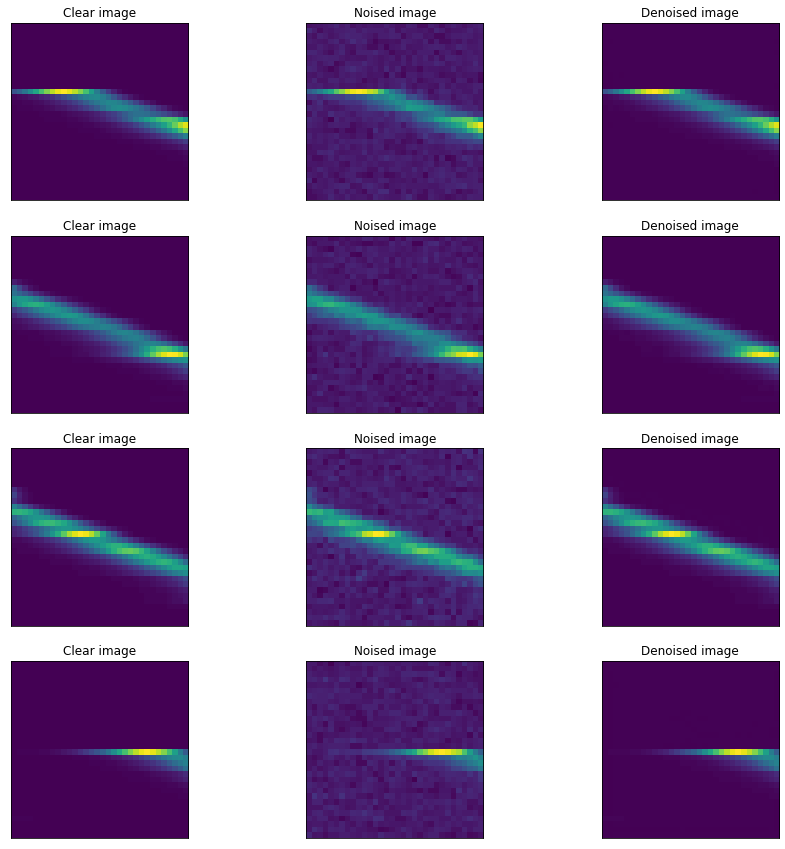


 77%|███████▋  | 14505/18750 [6:22:51<1:07:24,  1.05it/s]

KeyboardInterrupt: 

In [24]:
for ind, (image, noise_image) in enumerate(tqdm.tqdm(train_dataloader)):
    optim.zero_grad()
    image, noise_image = image.cuda(device), noise_image.cuda(device)
    denoise_image, perceptual_loss = model(image, noise_image)
    loss = loss_mse(image, denoise_image) + perceptual_loss
    loss.backward()
    optim.step()
    losses.append(loss.item())
    if ind % 10 == 0:
        print(ind, 'MSE: ', loss.item())
    if ind % 100 == 0:
        clear_output()
        plot_diff(image.cpu().view(-1, 32, 32).data.numpy(),
                  noise_image.cpu().view(-1, 32, 32).data.numpy(),
                  denoise_image.cpu().view(-1, 32, 32).data.numpy())

In [27]:
!mkdir SavedModels

In [29]:
torch.save(model, 'SavedModels/firstGCNN.model')
torch.save(model.state_dict(), 'SavedModels/firstGCNN.state_dict')


In [50]:
# PSNR
# TEST VALIDATION
# PERCEPTUAL LOSS
# SMART LOSSES
# PATCHES FOR BIG IMAGES